In [1]:
import sklearn.datasets
import urllib.request
from typing import Callable

import os
import numpy as np
from typing import Callable

from proxskip.data import DataLoader
from proxskip.types import ProximityOperator, Vector
from proxskip.model import Model
from proxskip.loss import LossFunction
from proxskip.optimizer import ProxSkip


In [2]:
w8a_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/w8a"

data_path = './w8a'
if not os.path.exists(data_path):
    f = urllib.request.urlretrieve(w8a_url, data_path)
A, b = sklearn.datasets.load_svmlight_file(data_path)

In [3]:
class ConsesusProx(ProximityOperator):
    def __call__(
        self,
        x: Vector,
        state: dict
    ):
        x_h_tp1 = state['x_h_tp1']
        avg_weight = np.zeros(shape=x_h_tp1[0].shape)

        for local_weight in x_h_tp1: 
            avg_weight += local_weight

        avg_weight /= len(x_h_tp1)
        return avg_weight

prox = ConsesusProx()

In [4]:
np.random.seed(705)

In [5]:
from proxskip.types import Vector


class W8ALinearModel(Model):
    def __init__(self, num_features: int, lambda_, weights=None):
        self.num_features = num_features
        if weights is None:
            self.weights = np.random.rand(num_features, 1)
        else:
            self.weights = weights.copy()
        self.lambda_ = lambda_
        
    def forward(self, x: Vector) -> Vector:
        """Forward pass of the model.
        
        Args:
            x: Input vector. Shape (batch_size, num_features).
            
        Returns:
            Output vector. Shape (batch_size, 1).
        """
        if x.ndim == 1:
            x = x.reshape(-1, 1)
        assert x.shape[1] == self.num_features, \
            f"Input shape does not match expected shape. {x.shape[1]} != {self.num_features}"

        # (B, N) x (N, 1) - > (B, 1)
        output = x @ self.weights
        if output.ndim == 1:
            output = output.reshape(-1, 1)

        assert output.shape == (x.shape[0], 1), \
            f"Output shape does not match expected shape. {output.shape} != {(x.shape[0], 1)}"
            
        return output
    
    def backward(self, x: Vector, upstream: Vector) -> Vector:
        """Backward pass of the model.
        
        Args:
            x: Input vector. Shape (batch_size, num_features).
            upstream: Upstream gradient. Shape (batch_size, 1).
            
        Returns:
            Gradient with respect to the input. Shape (batch_size, num_features).
        """
        output = self.forward(x)
        assert upstream.shape == output.shape, \
            f"Upstream gradient shape does not match output shape. {upstream.shape} != {output.shape}"
            
        grad = x.T @ upstream
        assert grad.shape == self.weights.shape, \
            f"Gradient shape does not match weights shape. {grad.shape} != {self.weights.shape}"
            
        return grad + self.lambda_ * self.params()
        
        # return self.weights @ upstream.T  + self.lambda_ * self.params()
    
    def params(self) -> Vector:
        return self.weights
    
    def update(self, params: Vector) -> None:
        self.weights = params

In [6]:
from proxskip.types import Vector


class SliceDataset(DataLoader):
    def __init__(self, A, b):
        self.X = A.toarray()
        self.y = b
        self.L = (np.linalg.norm(self.X, axis=1) ** 2).mean() / 4
    
    def get(self) -> tuple[Vector, Vector]:
        return self.X, self.y
    
    def total_size(self) -> int:
        return self.X.shape[0]

In [7]:
from proxskip.model import Model
from proxskip.types import Vector

class LogisticLoss(LossFunction):
    def __init__(self, lambda_) -> None:
        super().__init__()
        self.lambda_ = lambda_
        
    def upstream_gradient(self, m: Model, X: Vector, y: Vector) -> Vector:
        y_hat = m.forward(X)
        if y.ndim == 1:
            y = y[:, None]
        s = np.exp(y * y_hat)
        return (-y / (1 + s)) / y.shape[0]
            
    def loss(self, m: Model, X: Vector, y: Vector) -> Vector:
        if y.ndim == 1:
            y = y[:, None]
        y_hat = m.forward(X)
        s = np.exp(-y * y_hat)
        return np.log(1 + s).mean() + self.lambda_ * m.params().T @ m.params()


In [8]:
num_devices = 16

Ad = [A[i::num_devices] for i in range(num_devices)]
bd = [b[i::num_devices] for i in range(num_devices)]

min_size = min([A.shape[0] for A in Ad])
Ad = [A[:min_size] for A in Ad]
bd = [b[:min_size] for b in bd]

In [32]:
dataloaders = [SliceDataset(Ad[i], bd[i]) for i in range(num_devices)]
L = np.max(np.array([dataloader.L for dataloader in dataloaders]))
lambda_ = L / 1000
num_iterations = 5 * 10**3
comminucation_rate = 10
comminication_rounds = num_iterations // comminucation_rate
p = 1 / (10 * np.sqrt(10))
w0 = [np.random.rand(Ad[i].shape[1], 1) for i in range(num_devices)]

In [33]:
import os
import pickle
from scipy.optimize import minimize

if not os.path.exists('true_min.pkl'):
    # Finding true minimum to compare with
    def loss(w):
        return LogisticLoss(lambda_).loss(W8ALinearModel(A.shape[1], lambda_, w), A, b)

    res = minimize(loss, np.random.rand(A.shape[1]), method='BFGS', tol=1e-6)
    true_min = res.fun
    pickle.dump(true_min, open('true_min.pkl', 'wb'))
    print(res)
else:
    with open('true_min.pkl', 'rb') as f:
        true_min = pickle.load(f)


In [34]:
models = [
    W8ALinearModel(Ad[i].shape[1], lambda_, w0[i]) for i in range(num_devices)
]

loss_fn = LogisticLoss(lambda_)
l0_avg = np.mean([loss_fn.loss(models[i], *dataloaders[i].get()) for i in range(num_devices)])
print(f"l0_avg: {l0_avg}")


ps_optimizer = ProxSkip(
    models=models,
    dataloaders=dataloaders,
    loss=loss_fn,
    prox=ConsesusProx(),
    num_iterations=num_iterations ** 2, # to have `comminication_rounds` of loss values
    learning_rate=1 / L,
    p=p,
)

l0_avg: 6.057599022473408


In [35]:
from tqdm import trange

progress = trange(comminication_rounds)
c = 0
while True:
    on_prox = ps_optimizer.step()
    if on_prox is None or c == comminication_rounds:
        break
    if on_prox:
        progress.set_description(f"loss={ps_optimizer._step['loss'][-1].item():.4f}")
        progress.update(1)
        c += 1
        

loss=0.2462: 100%|██████████| 500/500 [05:31<00:00,  3.74it/s]

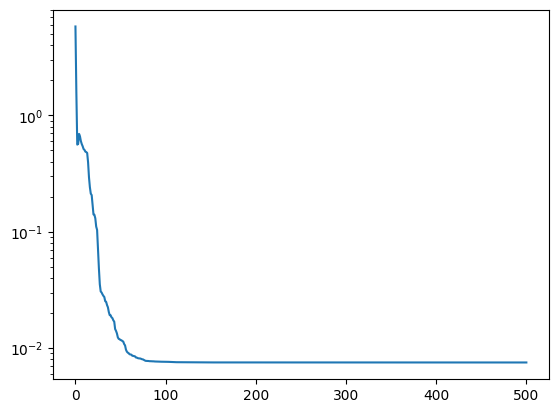

In [36]:
import matplotlib.pyplot as plt

proxskip_criterion = [np.array([[l0_avg - true_min]])] + [x - true_min for x in ps_optimizer._step['loss']]
plt.yscale('log')
plt.plot([x[0] for x in proxskip_criterion])

In [37]:
from proxskip.optimizer import LocalGD

lgd_optimizer = LocalGD(
    models=[W8ALinearModel(Ad[i].shape[1], lambda_, w0[i]) for i in range(num_devices)],
    dataloaders=dataloaders,
    loss=LogisticLoss(L / 1000),
    num_iterations=num_iterations,
    learning_rate=1 / L,
    communication_rate=comminucation_rate,
)

In [39]:
from tqdm import trange

progress = trange(num_iterations)

for _ in progress:
    on_prox = lgd_optimizer.step()
    if on_prox is None:
        break
    if on_prox:
        progress.set_description(f"loss={lgd_optimizer._step['loss'][-1].item():.4f}")

loss=0.2462:  90%|████████▉ | 4483/5000 [01:30<00:10, 49.63it/s]


In [40]:
lgd_steps = [np.array([[l0_avg - true_min]])] + [x - true_min for x in lgd_optimizer._step['loss']]

In [41]:
proxskip_criterion[0], lgd_steps[0]

(array([[5.81887978]]), array([[5.81887978]]))

In [45]:
np.min(proxskip_criterion), proxskip_criterion[-1]

(0.0075135940357170805, array([[0.00751359]]))

Text(0, 0.5, 'Loss')

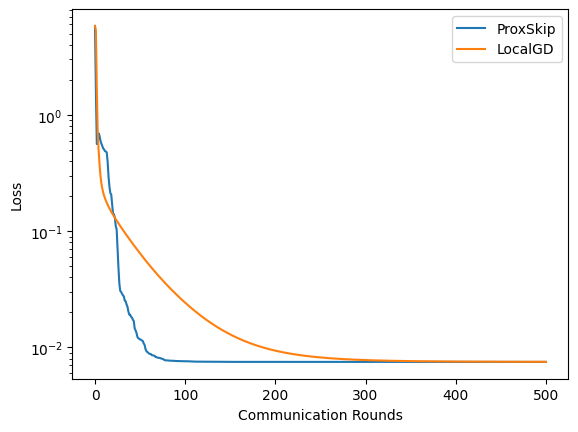

In [43]:
plt.plot([x[0] for x in proxskip_criterion])
plt.plot([x[0] for x in lgd_steps])
plt.legend(['ProxSkip', 'LocalGD'])
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('Communication Rounds')
plt.ylabel('Loss')